In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import pandas as pd
from tqdm import tqdm
import os
import natsort
from glob import glob
import numpy as np

# 멀티모달 

In [3]:
#Forest_test=np.load('Forest_test.npy')
Height_test=np.load('Height_test.npy')
NDVI_test=np.load('NDVI_test.npy')
Slope_test=np.load('Slope_test.npy')

#Forest_train=np.load('Forest_train.npy')
Height_train=np.load('Height_train.npy')
NDVI_train=np.load('NDVI_train.npy')
Slope_train=np.load('Slope_train.npy')

In [4]:
tabular_data_Train=pd.read_csv("Weather_data.csv",encoding='cp949',index_col='Unnamed: 0')
tabular_data_Train.drop(['field1', 'i', 'j', 'lon', 'lat', '날씨', '특보내용'],axis=1,inplace=True)
x,y=[],[]
for j in tqdm(range(len(tabular_data_Train))):
    x.append(np.array(tabular_data_Train.loc[j, ['습도', '강수', '기온', '풍속']]).astype(float))

    y.append(np.array(tabular_data_Train.loc[j, ['target']]).astype(float))
climate_train = np.array(x)
y_train = np.array(y)

100%|█████████████████████████████████████████████████████████████████████████████| 2145/2145 [00:02<00:00, 990.56it/s]


In [5]:
tabular_data_test=pd.read_csv("test_data.csv",index_col='Unnamed: 0')
tabular_data_test=tabular_data_test.replace(32767.0,-9999)
x=[]
for j in tqdm(range(len(tabular_data_test))):
    x.append(np.array(tabular_data_test.loc[j, ['hum', 'rain', 'temp', 'wind']]).astype(float))

climate_test = np.array(x)


100%|████████████████████████████████████████████████████████████████████████| 111200/111200 [00:48<00:00, 2315.88it/s]


In [6]:
#Forest_input = Input(shape=(64, 64, 3), name='Forest_input')
Height_input = Input(shape=(64, 64, 3), name='Height_input')
NDVI_input = Input(shape=(64, 64, 3), name='NDVI_input')
Slope_input = Input(shape=(64, 64, 3), name='Slope_input')
Climate_input = Input(shape=(4,1), name='Climate_input')

def cnn_layers(input_layer):
    conv1_im = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    pool1_im = MaxPooling2D(pool_size=(2,2))(conv1_im)
    conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1_im)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    flatten = Flatten()(pool2)
    dense1 = Dense(128, activation='relu')(flatten)
    return dense1

def dense_layer(input_layer):
    dense0 = Dense(64, activation='relu')(input_layer)
    dense1 = Dense(64, activation='relu')(dense0)
    flatten = Flatten()(dense1)
    dense2 = Dense(64, activation='relu')(flatten)
    return dense2
    
#Forest_cnn = cnn_layers(Forest_input)
Height_cnn = cnn_layers(Height_input)
NDVI_cnn = cnn_layers(NDVI_input)
Slope_cnn = cnn_layers(Slope_input)
Climate_cnn = dense_layer(Climate_input)

#merged = concatenate([Forest_cnn, Height_cnn, NDVI_cnn, Slope_cnn, Climate_cnn])
merged = concatenate([Height_cnn, NDVI_cnn, Slope_cnn, Climate_cnn])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(merged)

#model = Model(inputs=[Forest_input, Height_input, NDVI_input,Slope_input, Climate_input], outputs=output_layer)
model = Model(inputs=[Height_input, NDVI_input,Slope_input, Climate_input], outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Height_input (InputLayer)      [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 NDVI_input (InputLayer)        [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Slope_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['Height_input[0][0]']           
                                                                                              

In [7]:
x_train = {
    'Height_input': Height_train,
    'NDVI_input': NDVI_train,
    'Slope_input': Slope_train,
    'Climate_input':climate_train
}


In [8]:
x_test= {
    'Height_input': Height_test,
    'NDVI_input': NDVI_test,
    'Slope_input': Slope_test,
    'Climate_input':climate_test
}

In [9]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95:
            print("Reached accuracy threshold (0.95). Stopping training.")
            self.model.stop_training = True

In [10]:
model.fit(x_train, y_train, epochs=50, batch_size=128, callbacks=[AccuracyThresholdCallback()])

Epoch 1/50
17/17 [==============================] - 15s 835ms/step - loss: 0.5549 - accuracy: 0.7217
Epoch 2/50
17/17 [==============================] - 14s 829ms/step - loss: 0.4955 - accuracy: 0.7744
Epoch 3/50
17/17 [==============================] - 14s 826ms/step - loss: 0.4728 - accuracy: 0.7865
Epoch 4/50
17/17 [==============================] - 14s 824ms/step - loss: 0.4615 - accuracy: 0.7855
Epoch 5/50
17/17 [==============================] - 14s 826ms/step - loss: 0.4584 - accuracy: 0.7851
Epoch 6/50
17/17 [==============================] - 14s 828ms/step - loss: 0.4451 - accuracy: 0.7888
Epoch 7/50
17/17 [==============================] - 14s 829ms/step - loss: 0.4369 - accuracy: 0.8005
Epoch 8/50
17/17 [==============================] - 14s 830ms/step - loss: 0.4345 - accuracy: 0.7925
Epoch 9/50
17/17 [==============================] - 14s 836ms/step - loss: 0.4171 - accuracy: 0.8070
Epoch 10/50
17/17 [==============================] - 14s 826ms/step - loss: 0.4014 - accura

In [11]:
y_pred = model.predict(x_test)
y_pred

3475/3475 [==============================] - 226s 64ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [12]:
len(y_pred[y_pred>=0.5])

48196

In [13]:
del Height_test
del NDVI_test
del Slope_test

In [14]:
del Height_train
del NDVI_train
del Slope_train

In [15]:
result_arr = np.zeros((278, 400))
x = 0
for i in range(278):
    for j in range(400):
        value = y_pred[x]
        result_arr[i, j] = value-0.3  # 결과 배열에 값 추가
        x += 1
# 결과 배열 출력
print(result_arr)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


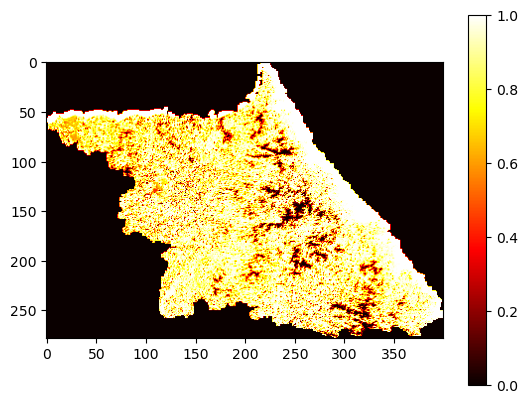

In [16]:
import matplotlib.pyplot as plt
# heatmap 플롯 생성
plt.imshow(result_arr, cmap='hot',vmax=1,vmin=0)
# 컬러바 추가
plt.colorbar()
plt.show()

<AxesSubplot:>

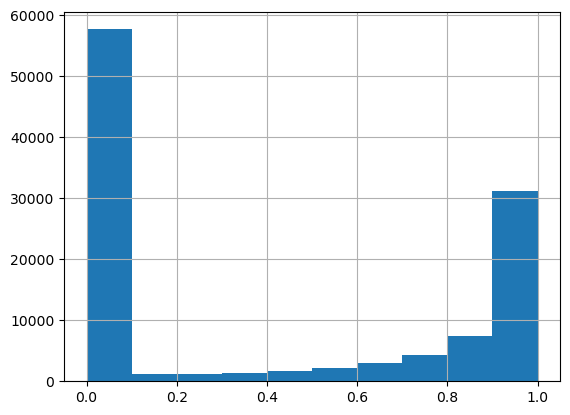

In [17]:
a=pd.DataFrame(y_pred.tolist())
a[0].hist()

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
Forest_files= natsort.natsorted(glob(f"C:/Users/EBDL/Desktop/Land/Train_data/Forest/*.tif"))
Height_files= natsort.natsorted(glob(f"C:/Users/EBDL/Desktop/Land/Train_data/Height/*.tif"))
NDVI_files= natsort.natsorted(glob(f"C:/Users/EBDL/Desktop/Land/Train_data/NDVI/*.tif"))
Slope_files= natsort.natsorted(glob(f"C:/Users/EBDL/Desktop/Land/Train_data/Slope/*.tif"))

In [ ]:
tif_list=[]
for i in range(len(Slope_files)):
    tmp = cv2.imread(Slope_files[i], cv2.IMREAD_COLOR)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    tmp = cv2.resize(tmp, (64, 64))
    tmp = tmp / 255.0
    tif_list.append(tmp)

test=np.array(tif_list)
np.save('Slope_train.npy',test)